#Big Data Aanalytics - Semester Project

##Team Members:
1.   Muhammad Jawad Bashir - 330295 - Did Coding (GL)
2.   Rizki Haleemdeen - 359407 - Did Data Visualization
3.   Abdul Subhan 326966 Report Write up

# Climate Change: Twitter Sentiment Analysis 

Climate change is one of the top priority issues for world governments. After IPCC issued CODE RED
about increasing temperature, if we don’t cut the emissions of carbon, our planet will have irreversible
catastrophic changes.
Purpose of this project is to analyze the public sentiment by gathering tweets from different people and
analyze their sentiment on climate change.
Twitter Sentiment Analysis is the process of determining Tweets is positive, negative or neutral. It is
known as opinion mining.

The dataset is collected by Harvard. It contains 40 million tweets about climate change (but we only took 300k tweets). 

Obviously data
are in an unstructured format. Also a huge amount of tweets is generated. So here the big data come
into action. The big data concepts like, Hadoop, MapReduce, Hadoop Distributed File System widely
used for this type of applications.

Analysis is targeting those with high influence, or who are vocal on the subject:
- High influence?
    - How many followers / fans that congressman has
    - Who they interact with most?
        - And about what?
- Vocal on subject?
    - What topics are most discussed in tweets?
        - Of those topics, who discusses them the most?
    - What is the sentiment of each tweet?

In [1]:
!pip install sparknlp
!pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sparknlp
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[4]")\
    .config("spark.driver.memory","4G")\
    .config("spark.driver.maxResultSize", "2G") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5")\
    .config("spark.kryoserializer.buffer.max", "1G")\
    .getOrCreate()
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from textblob import TextBlob

### Load / Cache Data
As we are using Google Colab, so following is the implementation accordingly:
- Spark dataframe should split into partitions = 2-3x the no. threads available in a CPU or cluster. For example, we have 2 cores, with 2 threads each = 4, and I chose 3x, ie. 12 partitions, based on experimentation.
- Then cache tables: you can see in Spark GUI that 12 partitions are cached for each file.
- The Shuffle Read is default to 200, we don't want this to be the bottleneck, so we set this equal to partitions in our data, using spark.sql.shuffle.partitions.

In [4]:
#tweets = spark.read.json('../Lobbyists4America1/US_PoliticalTweets/tweets.json').repartition(12).persist()
users = spark.read.json('/content/drive/MyDrive/Datasets/Tweets/climate_300k.json').repartition(12).persist()
#users = spark.read.csv('/content/drive/MyDrive/Datasets/Tweets/climate_300k.csv',sep=',',inferSchema=True, header=True).repartition(12).persist()
#users = spark.read.format("csv").option("header","true").option("inferSchema","true").load("/content/drive/MyDrive/Datasets/Tweets/climate_300k.csv")
spark.sql('SET spark.sql.shuffle.partitions=12')

DataFrame[key: string, value: string]

## User Schema

In [5]:
users.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

Select columns I will need from users file, and add rank columns I will use later:

In [6]:
users.createOrReplaceTempView('users')
spark.sql('SELECT * FROM users LIMIT 1').toPandas()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user,withheld_in_countries
0,None,None,Mon Aug 13 18:31:22 +0000 2018,"[0, 178]","([([0, 6], TypeR), ([34, 41], humour), ([60, 67], change), ([74, 81], stress), ([91, 101], workplace), ([112, 121], politics), ([128, 142], climatechange), ([145, 154], laughter)], None, [], [(mailchi.mp/ccda35b7914e/t…, https://mailchi.mp/ccda35b7914e/transforming-stress-type-r-spring-18-newsletter-334223, [155, 178], https://t.co/K0KpNjejmA)], [])",None,1,False,#TypeR updates &amp; the power of #humour amidst disruptive #change &amp; #stress from the #workplace to global #politics &amp; #climatechange . #laughter https://t.co/K0KpNjejmA,None,1029072938081890300,1029072938081890307,None,nan,None,nan,None,False,en,None,False,None,nan,None,None,0,False,None,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",False,"(False, Fri Dec 23 15:59:21 +0000 2011, False, False, #TypeR author, entrepreneur, speaker. Strategy, leadership, #TransformativeResilience, gender, purpose & policy. Art & nature lover. Feat NYT, HBR, CNN, BBC, (([],), ([Row(display_url='type-r-resilience.com', expanded_url='http://www.type-r-resilience.com', indices=[0, 23], url='https://t.co/s4SCLbQiNT')],)), 5142, False, 1173, False, 2719, True, False, 444745931, 444745931, False, False, None, 90, CA & NM + global (She/Her), Ama Marston, False, BADFCD, http://abs.twimg.com/images/themes/theme12/bg.gif, https://abs.twimg.com/images/themes/theme12/bg.gif, False, https://pbs.twimg.com/profile_banners/444745931/1515522791, http://pbs.twimg.com/profile_images/993805210727444481/9dsfY2eM_normal.jpg, https://pbs.twimg.com/profile_images/993805210727444481/9dsfY2eM_normal.jpg, 1B95E0, F2E195, FFF7CC, 0C3E53, True, False, AmaMarston, 3517, None, none, https://t.co/s4SCLbQiNT, None, False, [])",None


## Extracting Verified Users - Potential Influencers

In [7]:
users_verified = users.select('user.id','user.name','user.location','user.description','favorite_count',
                              'user.followers_count','user.friends_count','user.verified') \
                        .filter('verified == "True"')

# users_verified = users_verified.withColumn("followers_rank",
#                                            dense_rank().over(Window.orderBy(col("user.followers_count").desc())))\
#                                 .withColumn("friends_rank",
#                                            dense_rank().over(Window.orderBy(col("user.friends_count").desc())))\
#                                 .withColumnRenamed('user.id','id_user')

In [8]:
users_verified = users_verified.withColumn("followers_rank",
                                           dense_rank().over(Window.orderBy(col("followers_count").desc())))\
                                .withColumn("friends_rank",
                                           dense_rank().over(Window.orderBy(col("friends_count").desc())))\
                                .withColumnRenamed('user.id','id_user')

In [9]:
users_verified.toPandas()

,id,name,location,description,favorite_count,followers_count,friends_count,verified,followers_rank,friends_rank
0,91942071,🟣 Bobby Umar | Keynote Speaker,"Toronto, Canada, US","5x @TEDx | Inc Mag Top 100 Speaker, Heart-Leader, Networking, Personal Brand, Storytelling & Parenting | Coach, Author, TV Host, Comedy Actor, GMAT pro, Daddy",0,503763,213787,True,351,1
1,154311445,Steve Westly,"Menlo Park, CA","Entrepreneur, Venture Capitalist, former Controller & CFO of the State of California.",81,213953,204094,True,642,2
2,154311445,Steve Westly,"Menlo Park, CA","Entrepreneur, Venture Capitalist, former Controller & CFO of the State of California.",106,213952,204092,True,643,3
3,154311445,Steve Westly,"Menlo Park, CA","Entrepreneur, Venture Capitalist, former Controller & CFO of the State of California.",79,213950,204092,True,644,3
4,16667912,Independent Women's Forum,"Washington, D.C.","@IWF works to develop and advance policies that aren’t just well intended but actually enhance freedom, opportunities, and well-being.",6,302358,169225,True,500,4
...,...,...,...,...,...,...,...,...,...,...
6933,2698831530,Floskelwolke,Deutschland Österreich Schweiz,Sprach- und Medienkritik | Tägliche Analyse von Floskeln in deutschsprachigen Nachrichten | Journalistisches Medienprojekt von @UdoStiehl & Sebastian @Pertsch.,0,20719,2,True,2290,2679
6934,45075214,Siasat.pk,Pakistan,Pakistan's biggest digital media platform - Discussion forum & News blogs. Founder & editor @adeel786,110,1516374,1,True,150,2680
6935,2515925815,GC Newsroom,Canada,Government of Canada Newsroom: News Centre. Terms of Use: https://t.co/ImDc1BXR4W En français: @salledepresseGC,3,65326,1,True,1313,2680
6936,2515925815,GC Newsroom,Canada,Government of Canada Newsroom: News Centre. Terms of Use: https://t.co/ImDc1BXR4W En français: @salledepresseGC,1,65326,1,True,1313,2680


## Top Influencers

In [10]:
query = '''
SELECT user.name, user.followers_count
FROM users
ORDER BY user.followers_count DESC
'''
spark.sql(query).show()

+--------------------+---------------+
|                name|followers_count|
+--------------------+---------------+
|                 CNN|       55771165|
|            Fox News|       20538629|
|The Wall Street J...|       19321382|
|       Kamala Harris|       19124799|
|       Kamala Harris|       19124710|
|       Kamala Harris|       19124689|
| The Washington Post|       18579465|
| The Washington Post|       18579443|
| The Washington Post|       18579414|
| The Washington Post|       18579414|
|                TIME|       18508482|
|                TIME|       18508416|
|              Forbes|       17362697|
|              Forbes|       17362644|
|            ABC News|       17025615|
|            ABC News|       17025579|
|  President of India|       16158059|
|The Associated Press|       15418354|
|The Associated Press|       15418274|
|      United Nations|       14735144|
+--------------------+---------------+
only showing top 20 rows



## Top Socials

In [11]:
query2 = '''
SELECT user.name, user.friends_count
FROM users
ORDER BY user.friends_count DESC
'''
spark.sql(query2).show()

+--------------------+-------------+
|                name|friends_count|
+--------------------+-------------+
|       Jeffrey Levin|       583842|
|       Jeffrey Levin|       583821|
|       Jeffrey Levin|       583821|
|       Jeffrey Levin|       583815|
|       Jeffrey Levin|       583815|
|       Jeffrey Levin|       583815|
|       Jeffrey Levin|       583815|
|Sarah ☮ & █▄❤️╲╱☰...|       441751|
|          TwiterHero|       307191|
|    Burton Brown Sr.|       290841|
|       Shmoo Report.|       285828|
|       Shmoo Report.|       285828|
|       Shmoo Report.|       285828|
|Evan Kirstel #Tec...|       280236|
|Evan Kirstel #Tec...|       280236|
|Evan Kirstel #Tec...|       280236|
|Evan Kirstel #Tec...|       280236|
|Evan Kirstel #Tec...|       280236|
|Evan Kirstel #Tec...|       280234|
|Dr Robert Bohan A...|       263881|
+--------------------+-------------+
only showing top 20 rows



## Most Liked Tweets

In [12]:
query = '''
SELECT user.name, favorite_count
FROM users
ORDER BY favorite_count DESC
'''
spark.sql(query).show()

+--------------------+--------------+
|                name|favorite_count|
+--------------------+--------------+
|          Peter Daou|          9412|
|Vice President Ka...|          8936|
|      Bernie Sanders|          7374|
|       Shannon Watts|          5244|
|         Nate Lerner|          4910|
|       Ryan Knight ☭|          4660|
|        Brian Schatz|          4373|
|       Kamala Harris|          4209|
|    Alberto Nardelli|          4208|
|       Bill McKibben|          4199|
|             Forward|          3894|
|       Kamala Harris|          3448|
|        Ken Jennings|          2949|
|     Joe Kennedy III|          2517|
|          Adam McKay|          1920|
|             Kathryn|          1865|
|  Lawrence O'Donnell|          1823|
|     The Babylon Bee|          1732|
|  Jane Seymour Fonda|          1550|
|        John Stossel|          1512|
+--------------------+--------------+
only showing top 20 rows



## Users Distribution

Total no. verified users on twitter: 6938

 Below we see there are a few members with a large following, and many friends. These could be influential in pushing a lobbyist's cause 



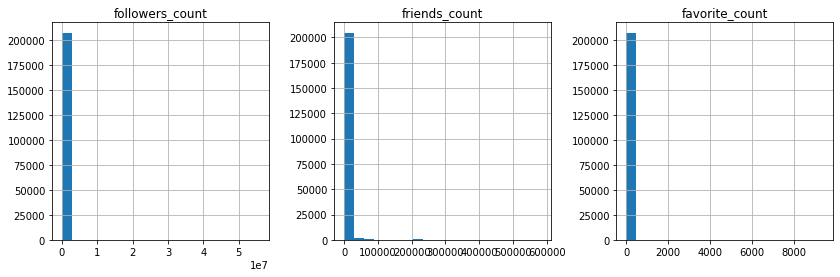

In [13]:
print('Total no. verified users on twitter:', users.filter('user.verified == "true"').count())
print("\n Below we see there are a few members with a large following, and many friends. These could be influential in pushing a lobbyist's cause \n")

fig, ax = plt.subplots(ncols=3, figsize=(14,4))
users.select('user.followers_count').toPandas().hist(bins=20, ax=ax[0])
users.select('user.friends_count').toPandas().hist(bins=20, ax=ax[1])
users.select('favorite_count').toPandas().hist(bins=20, ax=ax[2]);

## Analyzing Tweets data

Select columns We will need from tweets file:

In [32]:
query = '''
SELECT id, user.id, created_at, favorite_count, retweet_count, 
users.entities.hashtags.text AS hashtags, users.entities.user_mentions.id AS mentioned_user_id, 
full_text, in_reply_to_user_id
FROM users
'''
spark.sql(query).show(5,truncate=8)

+--------+--------+----------+--------------+-------------+--------+-----------------+---------+-------------------+
|      id|      id|created_at|favorite_count|retweet_count|hashtags|mentioned_user_id|full_text|in_reply_to_user_id|
+--------+--------+----------+--------------+-------------+--------+-----------------+---------+-------------------+
|10290...|44474...|  Mon A...|             1|            0|[Type...|               []| #Type...|               null|
|10290...|86273...|  Mon A...|             0|            1|[Rene...|         [8029...| RT @K...|               null|
|10290...|19112146|  Mon A...|             0|            7|      []|         [5946...| RT @t...|               null|
|10289...|70852...|  Mon A...|             0|            0|      []|         [2942...| @Eddy...|           29420301|
|10291...|18846...|  Mon A...|             0|         2177|      []|         [2944...| RT @S...|               null|
+--------+--------+----------+--------------+-------------+-----

In [16]:
from pyspark.sql.functions import to_timestamp,date_format

In [17]:
spark.sql('SELECT * FROM users LIMIT 2').toPandas()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user,withheld_in_countries
0,None,None,Mon Aug 13 18:31:22 +0000 2018,"[0, 178]","([([0, 6], TypeR), ([34, 41], humour), ([60, 67], change), ([74, 81], stress), ([91, 101], workplace), ([112, 121], politics), ([128, 142], climatechange), ([145, 154], laughter)], None, [], [(mailchi.mp/ccda35b7914e/t…, https://mailchi.mp/ccda35b7914e/transforming-stress-type-r-spring-18-newsletter-334223, [155, 178], https://t.co/K0KpNjejmA)], [])",None,1,False,#TypeR updates &amp; the power of #humour amidst disruptive #change &amp; #stress from the #workplace to global #politics &amp; #climatechange . #laughter https://t.co/K0KpNjejmA,None,1029072938081890300,1029072938081890307,None,nan,None,nan,None,False,en,None,False,None,nan,None,None,0,False,None,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",False,"(False, Fri Dec 23 15:59:21 +0000 2011, False, False, #TypeR author, entrepreneur, speaker. Strategy, leadership, #TransformativeResilience, gender, purpose & policy. Art & nature lover. Feat NYT, HBR, CNN, BBC, (([],), ([Row(display_url='type-r-resilience.com', expanded_url='http://www.type-r-resilience.com', indices=[0, 23], url='https://t.co/s4SCLbQiNT')],)), 5142, False, 1173, False, 2719, True, False, 444745931, 444745931, False, False, None, 90, CA & NM + global (She/Her), Ama Marston, False, BADFCD, http://abs.twimg.com/images/themes/theme12/bg.gif, https://abs.twimg.com/images/themes/theme12/bg.gif, False, https://pbs.twimg.com/profile_banners/444745931/1515522791, http://pbs.twimg.com/profile_images/993805210727444481/9dsfY2eM_normal.jpg, https://pbs.twimg.com/profile_images/993805210727444481/9dsfY2eM_normal.jpg, 1B95E0, F2E195, FFF7CC, 0C3E53, True, False, AmaMarston, 3517, None, none, https://t.co/s4SCLbQiNT, None, False, [])",None
1,None,None,Mon Aug 13 18:51:59 +0000 2018,"[0, 140]","([([92, 108], RenewableEnergy), ([109, 123], ClimateChange)], None, [], [], [(802995063278055400, 802995063278055424, [3, 19], Kathryn Kicklighter🌊🌊🌊, KathrynKickligh)])",None,0,False,"RT @KathrynKickligh: 😡 Please, someone with more knowledge than I have respond to this. ... #RenewableEnergy #ClimateChange https://t.co/Ek…",None,1029078127987830800,1029078127987830784,None,nan,None,nan,None,False,en,None,None,None,nan,None,None,1,False,"(None, None, Mon Aug 13 18:48:51 +0000 2018, [0, 126], ([Row(indices=[71, 87], text='RenewableEnergy'), Row(indices=[88, 102], text='ClimateChange')], None, [], [Row(display_url='apple.news/AyanM_c2qONGZ6…', expanded_url='https://apple.news/AyanM_c2qONGZ6f_x0McllQ', indices=[103, 126], url='https://t.co/Ek431nsvf8')], []), None, 1, False, 😡 Please, someone with more knowledge than I have respond to this. ... #RenewableEnergy #ClimateChange https://t.co/Ek431nsvf8, None, 1029077339630489600, 1029077339630489600, None, None, None, None, None, False, en, None, False, None, None, None, None, 1, False, None, <a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>, False, (False, Sun Nov 27 21:58:36 +0000 2016, True, False, Fights #Authoritarianism & #ClimateScienceDeniers everywhere. #liberal #BLM✊🏻✊🏽✊🏿 #ClimateAction #LGBTQ ally 🚫DM’s. Vaccinated & boosted., (Row(urls=[]), None), 24989, False, 15897, False, 15880, False, True, 802995063278055400, 8029950632780...","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Mobile Web (M2)</a>",False,"(False, Thu May 11 18:11:26 +0000 2017, True, True, , (([],), None), 115592, False, 1514, False, 3145, False, False, 862731889291001900, 862731889291001856, False, False, None, 0, , gene hill, False, 

## Finding Top Mentions

In [18]:
query = '''
SELECT users.entities.user_mentions.name AS mentions, COUNT(*) as cnt
FROM users
GROUP BY mentions
ORDER BY cnt DESC
'''
spark.sql(query).show()

+--------------------+-----+
|            mentions|  cnt|
+--------------------+-----+
|                  []|48442|
|       [Paul Dawson]| 4213|
|[Andrew Wortman ?...| 3814|
|        [Peter Daou]| 2554|
|     [Kamala Harris]| 2522|
|  [Alberto Nardelli]| 2417|
|       [Mike Hudema]| 2086|
|    [Bernie Sanders]| 2028|
|       [Ryan Knight]| 1894|
|      [Brian Schatz]| 1794|
|      [Kate Aronoff]| 1674|
|           [Forward]| 1303|
|       [Nate Lerner]| 1273|
|        [Greenpeace]| 1070|
|       [Daniel Dale]| 1006|
|      [John Oberlin]|  974|
|[President Biden,...|  935|
|     [Shannon Watts]|  912|
|          [Sadhguru]|  908|
|  [Richard D. Wolff]|  703|
+--------------------+-----+
only showing top 20 rows



## Popular HashTags

In [19]:
query = '''
SELECT users.entities.hashtags.text AS hashtags, COUNT(*) as cnt
FROM users
GROUP BY hashtags
ORDER BY cnt DESC
'''
spark.sql(query).show()

+--------------------+------+
|            hashtags|   cnt|
+--------------------+------+
|                  []|152189|
|     [climatechange]|  6216|
|     [ClimateChange]|  2977|
|[climatechange, c...|   845|
|     [Climatechange]|   704|
|[ClimateChangeIsR...|   569|
|            [Europe]|   521|
|           [climate]|   500|
|               [NEG]|   443|
|      [ActOnClimate]|   423|
|     [GlobalWarming]|   294|
|            [auspol]|   281|
|             [QandA]|   253|
|[climatechange, E...|   251|
|            [Brexit]|   233|
|     [globalwarming]|   213|
|    [RenewablePower]|   197|
|[climate, stoppip...|   189|
|           [Climate]|   174|
|    [ParisAgreement]|   169|
+--------------------+------+
only showing top 20 rows



## Finding usage of #ParisAccord and #ParisAgreement

In [20]:
user_tags = users.select(users.entities.hashtags.text.alias('hashtags'),'id','created_at')

user_tags \
    .withColumn('hashtags', user_tags['hashtags'].getItem(0).cast("string")) \
    .filter('hashtags IN ("ParisAccord","ParisAgreement")') \
    .groupby('hashtags','id').count().sort('count',ascending=False) \
    .join(users.select(users.id.alias('id'),'user.name'), on='id') \
    .show()

+-------------------+--------------+-----+--------------------+
|                 id|      hashtags|count|                name|
+-------------------+--------------+-----+--------------------+
|1029241530882486300|ParisAgreement|    1|        Chris Aikman|
|1029097754138746900|ParisAgreement|    1|                Ruth|
|1029094901860855800|ParisAgreement|    1|        David Atkins|
|1029275880366006300|ParisAgreement|    1|        david bieber|
|1030179769852280800|ParisAgreement|    1|  Murray Shackleford|
|1029309781209538600|ParisAgreement|    1|       Nayana G Nair|
|1029304102247981000|ParisAgreement|    1|         Nina Teneva|
|1030572957448384500|ParisAgreement|    1|        Noel Lovejoy|
|1029346725331456000|   ParisAccord|    1|Trinity College D...|
|1029317276665819100|ParisAgreement|    1|           Steve May|
|1029332608641953800|ParisAgreement|    1|           Mary Ping|
|1029626986451427300|ParisAgreement|    1|    Energy in Demand|
|1029159354862383100|ParisAgreement|    

## Finding usage of #ClimateChange

In [31]:
user_tags \
    .withColumn('hashtags', user_tags['hashtags'].getItem(0).cast("string")) \
    .filter('hashtags IN ("ClimateChange")') \
    .groupby('hashtags','id').count().sort('count',ascending=True) \
    .join(users.select(users.id.alias('id'),'user.name'), on='id') \
    .show()

+-------------------+-------------+-----+--------------------+
|                 id|     hashtags|count|                name|
+-------------------+-------------+-----+--------------------+
|1029066378714603500|ClimateChange|    1|             Yes2Pot|
|1028997101068447700|ClimateChange|    1|                 CDP|
|1028994318478917600|ClimateChange|    1|               linda|
|1028971930928459800|ClimateChange|    1|The Carbon Litera...|
|1029246253681594400|ClimateChange|    1|JEFF FANDL - Pro ...|
|1029189435257184300|ClimateChange|    1|      impakterdotcom|
|1029148187070738400|ClimateChange|    1|   Prime Nkezumukama|
|1029328211673575400|ClimateChange|    1|     Pissy Chick™ 🐥|
|1029329009358688300|ClimateChange|    1|       L🐎L🐴Garrett|
|1029437001726971900|ClimateChange|    1|      Sohag Matubber|
|1029417404227641300|ClimateChange|    1|      Rishabh Razdan|
|1029395372404355100|ClimateChange|    1|EVAQ8 Emergency Kits|
|1029552016455073800|ClimateChange|    1|Workers of the Wo

## Removing Stop Words - A Clean Corpus
- Interesting to see the progression of sentiment about climate change over the years
- Most tweets didn't contain hashtags, so in order to widen the field, We may use a Word Vectorizer to parse out the key themes across all tweets.
- We will use NLTK's list of stopwords to conduct stopword removal.

In [22]:
!pip install nltk

In [23]:
!python -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
def dateconv(t):
  date = datetime.strftime(datetime.strptime(t,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')
  return date
udf_dateconv = udf(dateconv)
spark.udf.register("udf_dateconv", udf_dateconv)
users = users.withColumn("created_at", udf_dateconv(col("created_at")))

In [25]:
def remove_stopwords(x):    
    sw = "/root/nltk_data/corpora/stopwords/english"
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
        else:
            pass
    return string

nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)
users = users.withColumn('text_nosw',nosw('full_text'))

## Entity Recognition
- The issue with the Bag of Words approach is that non-descriptive words come to the top, which aren't stopwords.
- We turn to Spark NLP's entity recognition now to filter only on Entities which would better bring popular themes i.e. Paris Accord etc to the surface

## Thematic Sentiment Analysis
- Use TextBlob to assign sentiment to each tweet

In [26]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
users = users.withColumn('sentiment',sentiment('full_text').cast('double'))

In [27]:
users.select('sentiment').toPandas()

,sentiment
0,0.00
1,0.50
2,0.07
3,-0.25
4,0.00
...,...
207839,0.00
207840,-0.71
207841,0.00
207842,0.04


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34244cba10>]],
      dtype=object)

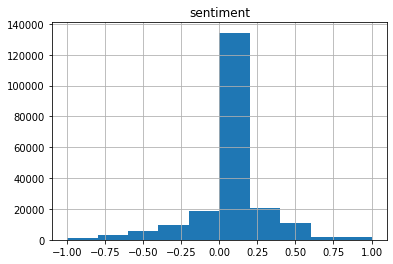

In [30]:
users.select('sentiment').toPandas().hist()

##### Headline Summary:
- Sentiment is generally very Neutral, however skewed towards the positive. Influencers and Government Agencies tend to be advocates for climate change issues, and generate support through proposed solutions.

## Sentiment Progression
Below we will chart the progression of sentiment and volume of tweets over time, and repeat this for climate change

In [ ]:
def make_string(x):
    string = ''
    for x in x:
        string += x + ' '
    return string

make_string = udf(make_string)
spark.udf.register("make_string", make_string)

pipeline = PretrainedPipeline('explain_document_dl', 'en')

tweets_sent = pipeline.transform(users.select('id','text','created_at','sentiment','user_id'))\
                            .select('id','text','created_at',col('entities.result').alias('entities'),col('pos.result').alias('pos'),'sentiment','user_id')\
                            .withColumn('entities',make_string('entities'))\
                            .withColumn('pos',make_string('pos'))

def plot_trend(chart_title, with_filter=False, filter_string=None, sentiment_sdf=tweets_sent, rolling_window=90):
    ''' Plot trend in sentiment and number of tweets, with the ability to customise several features:
    
    Args:
    chart_title: str. Customise chart title to clarify what you're plotting to the reader
    with_filter: boolean. if set to True, will require filter_string to be populated. if set to False, will 
                            allow you to plot trend without filters.
    filter_string: str. filter string that should be passed into Spark Dataframe API's .filter()
    sentiment_sdf: Spark Dataframe. Input dataframe.
    rolling_window: int. Set to number of lookback days to use in calculating moving average
    
    Returns:
    Moving average plot of num_tweets and sentiment, based on any filtering applied.
    
    '''
    
    if with_filter:
        trend_pdf = sentiment_sdf.select(to_date(from_unixtime(col('created_at'))).alias('date'),
                                   'sentiment','id')\
                            .filter(str(filter_string))\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()

    else:
        trend_pdf = sentiment_sdf.select(to_date(from_unixtime(col('created_at'))).alias('date'),
                                   'sentiment','id')\
                            .groupby('date').agg({'sentiment':'avg','id':'count'})\
                            .orderBy('date')\
                            .withColumnRenamed('avg(sentiment)','sentiment')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()
        
    rolling_sentiment = trend_pdf.sentiment.rolling(window=rolling_window).mean()
    rolling_tweets = trend_pdf.num_tweets.rolling(window=rolling_window).mean()

    fig, ax = plt.subplots(figsize=(10,4), sharex=True)
    fig.suptitle('{}'.format(chart_title))
    ax0 = plt.subplot(111)
    ax1 = ax0.twinx()

    ax0.plot(trend_pdf.date, rolling_sentiment, label='sentiment_ma')
    ax0.legend(loc='upper left')
    ax1.plot(trend_pdf.date, rolling_tweets, label='tweets_ma', c='k')
    ax1.legend(loc='lower right');

#Overall Sentiment Trend about Climate Change 

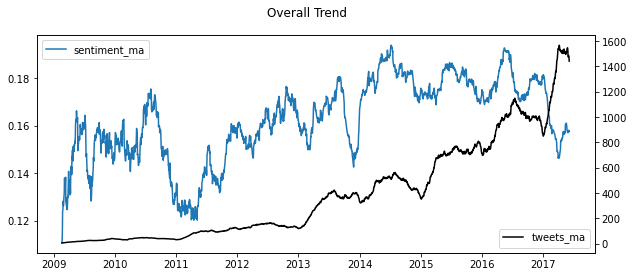

In [ ]:
plot_trend('Overall Trend')

1. The Overall Trend shows sentiment in earlier tweets was more volatile than later, this could simply be due to a higher sample size in the latter period
2. Overall the rolling average sentiment is always in positive territory, not a surprise as many influencers/goverment agencies use Twitter to increase awareness and generate support for climate issues.

#### Conclusions:
- We can see the increased concern about climate change over the years 

## Next Steps
1. This approach can be easily replicated to find clusters for different themes and goals, e.g. green energy, fossil fuel cut, electric vehicles, CodeRed, IPCC policies, etc.